# Tunable Parameters for the NISAR GCOV processor
The L2_L_GCOV standard product is produced using the NISAR GCOV processor driven by a standard set of configuration parameters. The **on-demand/algorithm development environment (ADE)** provides users with the capability to tweak these parameters and run them on an **on-demand NISAR Science Data System (SDS)** to generate custom L2_L_GOV products:

- *fullcovariance*: {optional} Compute cross-elements (True) or diagonals only (False). Default: False
- *output_type*: {optional} Choices: “None” (to turn off RTC) or “gamma0”; The *output_type* indicates the type of RTC that should be applied.
- *algorithm_type*: {optional} Choices: "area-projection" (default) and "David-Small"; The *algorithm_type* defines the algorithm used for computing the RTC area factor.
- *abs_rad_cal*: {optional} Absolute radiometric correction factor. Default 1
- *output_posting*: {required} Output posting in same units as output EPSG. Single value or list indicating the output posting for each frequency. Default "[20, 100]"; The *output_posting* is the distance between pixels of the output geogrid. *output_posting* and the *outputEPSG* spatial reference system parameter must have the same units. If the outputEPSG is not set, the output EPSG will be the same as the input DEM. The default value for *output_posting* is given by the list [20, 100], which defines 20m posting for the main band (frequency A) and 100m posting for the auxiliary band (frequency B). It is the responsibility of the user to ensure that *output_posting* values are consistent with *outputEPSG* (or DEMFile if applicable).

In this tutorial, we show you:
- how to submit a GCOV processor job to the **on-demand NISAR SDS** using an input L1_L_RSLC dataset to generate a standard L2_L_GCOV product using the default configuration parameters
- submit a second GCOV processor job to the **on-demand NISAR SDS** using the same input L1_L_RSLC dataset to generate a custom L2_L_GCOV product using tweaked parameters

<span style="color:red">**NOTE**: the L2_L_GCOV products generated in this notebook were produced by the R1 release (July 2020) of the GCOV processor (and its associated test data) which does not provide full-covariance matrix capabilities. Any visualizations will accordingly show no data.</span>

## Setup configuration for interaction with on-demand NISAR SDS
In this section, we setup the necessary python libraries and API endpoints needed to interact with the **on-demand NISAR SDS**. We print out the versions of the installed SAR-related python packages included in the on-demand environment: **ISCE2**, **ISCE3**, **PLAnT**, **ARIAtools**, and **MintPy**.

The `otello` python library provides high-level access to operations on the on-demand SDS. In particular for this demo, it provides us with access to and information about the job types registered on the SDS along with the capability to submit jobs, check for job statuses, and to query for products generated by the job.

The `pele` python library provides high-level read-only access to the dataset catalog managed by the on-demand SDS. In particular for this demo, it provides us with the capability to list the dataset types contained in the catalog, query for individual dataset granules of a particular dataset type, and to return metadata pertaining to an individual dataset granule.

### What version of SAR-related python packages/libraries are installed in the on-demand environment?

In [1]:
import os

# this block makes sure the directory set-up/change is only done once and relative to the notebook's directory
try:
    start_dir
except NameError:
    start_dir = os.getcwd()
    !mkdir -p ./notebook_output/05-Tunable_Parameters
    os.chdir('notebook_output/05-Tunable_Parameters')
    
import json
import time
import re
import shutil
from glob import glob
from pprint import pprint
from datetime import datetime
from pip._internal.commands.show import search_packages_info
import logging
import matplotlib
logging.getLogger('matplotlib').setLevel(logging.WARNING)

import otello
from pele.lib.client import PeleRequests

import isce as isce2
import pybind_isce3
import ARIAtools
import mintpy
import plant
%matplotlib inline

print(f"ISCE2 version: {isce2.__version__}")
try:
    isce3_version = pybind_isce3.__version__
except AttributeError:
    isce3_version = "undetermined"
print(f"ISCE3 version: {isce3_version}")
print(f"MintPy version: {mintpy.__version__}")
print(f"PLAnT version: {plant.__version__}")
print(f"ARIAtools version: {list(search_packages_info(['ARIAtools']))[0]['version']}")

Using default ISCE Path: /opt/isce2/isce
Using default MintPy Path: /opt/MintPy
ISCE2 version: 2.5.1
ISCE3 version: 0.2.0+30a23678
MintPy version: v1.3.0-8
PLAnT version: 0.1.57dev
ARIAtools version: 1.0


### Configure for interaction with the on-demand NISAR SDS

In [37]:
# set the mozart IP
mozart_ip = "100.64.122.59"
#mozart_ip = input("Enter IP address of your mozart instance then press <Enter>: ")
print(f"Using mozart IP address {mozart_ip}.")

# instantiate otello and get mozart object to interact with SDS
otello.client.initialize()
m = otello.mozart.Mozart()

# set pele URL
pele_url = f"https://{mozart_ip}/pele/api/v0.1"
print(f"Using pele URL {pele_url}.")

# instantiate PeleRequests object
pr = PeleRequests(pele_url, verify=False)

Using mozart IP address 100.64.122.59.
HySDS host (current value: https://100.64.122.59): https://100.64.122.176
Username (current value: jdyoung): 
HySDS cluster authenticated (y/n): n

auth: false
host: https://100.64.122.176
username: jdyoung

Using pele URL https://100.64.122.59/pele/api/v0.1.


## Submitting an "on-demand standard product" job for the NISAR GCOV processor
### Next let's get more information on the NISAR GCOV processor:

In [38]:
# get GCOV job type and initialize
job_type = "job-SCIFLO_GCOV:ade-test-2"
gcov = m.get_job_types()[job_type]
gcov.initialize()

### Let's print the input parameters for the GCOV processor:

In [39]:
print(gcov.describe())

Job Type: job-SCIFLO_GCOV:ade-test-2
Label: SCIFLO_GCOV


Tunable Parameters:
	name: processing_type
	type: enum
	choices: ['forward', 'reprocessing', 'urgent']
	default: forward

	name: fullcovariance
	type: enum
	choices: ['False', 'True']
	default: False

	name: output_type
	type: enum
	choices: ['None', 'gamma0']
	default: gamma0

	name: algorithm_type
	type: enum
	choices: ['area_projection', 'bilinear_distribution']
	default: area_projection

	name: output_posting
	type: text
	default: [20, 100]


Dataset Parameters:
	name: product_paths

	name: product_metadata

	name: input_dataset_id

	name: dataset_type


None


### Query NISAR SDS for input RSLC dataset
The input dataset for the NISAR GCOV processor is the NISAR RSLC product. Here we query the on-demand NISAR SDS for our such an input dataset:

In [40]:
# get input RSLC dataset
r = pr.get(f"{pele_url}/pele/dataset/NISAR_L1_PR_RSLC_001_001_D_001_2800_HH_20061007T061005_20061007T061005_D00101_P_F_001")
rslc_dataset = r.json()["result"]

### Prepare input for the on-demand GCOV processor

In [41]:
# set dataset params
gcov.set_input_dataset(rslc_dataset)

### Show the current configured parameter values

In [42]:
# what are my currently set parameters?
pprint(gcov.get_input_params())

{'algorithm_type': 'area_projection',
 'fullcovariance': 'False',
 'output_posting': '[20, 100]',
 'output_type': 'gamma0',
 'processing_type': 'forward'}


### Submit the GCOV job to run in the on-demand NISAR SDS

Note that we are explicitly overriding the default job queue in the submit_job call to specify the (only) one available in the Beta PCM environment.

In [46]:
# submit job
job1 = gcov.submit_job(tag="gcov-test1-default-params", queue="nisar-job_worker-small")

### Let's wait for the job to complete generation of the standard GCOV product

In [47]:
# wait for job
job1.wait_for_completion()

Tag: gcov-test1-default-params, ID: <724aa4d8-c9b4-44fc-96c0-573b6ef296a9>: job-started 2021-04-01T20:47:12.165611
Tag: gcov-test1-default-params, ID: <724aa4d8-c9b4-44fc-96c0-573b6ef296a9>: job-started 2021-04-01T20:47:42.213925
Tag: gcov-test1-default-params, ID: <724aa4d8-c9b4-44fc-96c0-573b6ef296a9>: job-started 2021-04-01T20:48:12.261218
Tag: gcov-test1-default-params, ID: <724aa4d8-c9b4-44fc-96c0-573b6ef296a9>: job-started 2021-04-01T20:48:42.297139
Tag: gcov-test1-default-params, ID: <724aa4d8-c9b4-44fc-96c0-573b6ef296a9>: job-started 2021-04-01T20:49:12.324960
Tag: gcov-test1-default-params, ID: <724aa4d8-c9b4-44fc-96c0-573b6ef296a9>: job-completed 2021-04-01T20:49:42.372538


'job-completed'

### Get information about the generated standard GCOV product from the GCOV job
#### The generated standard GCOV product is stored in the cloud next to the on-demand NISAR SDS

In [48]:
std_prod = job1.get_generated_products()
print(json.dumps(std_prod, indent=2, sort_keys=True))

[
  {
    "browse_urls": [
      "http://nisar-dev-rs-fwd-jdyoung.s3-website-us-west-2.amazonaws.com/browse/L2_L_GCOV/2019/07/17/NISAR_L2_PR_GCOV_001_001_D_001_2800_HH_20190717T231626_20190717T232116_D00001_P_F_001",
      "s3://s3-us-west-2.amazonaws.com:80/nisar-dev-rs-fwd-jdyoung/browse/L2_L_GCOV/2019/07/17/NISAR_L2_PR_GCOV_001_001_D_001_2800_HH_20190717T231626_20190717T232116_D00001_P_F_001"
    ],
    "dataset": "L2_L_GCOV",
    "dataset_level": "L2",
    "dataset_type": "L2_L_GCOV",
    "disk_usage": 363528396,
    "duration": 19.124117,
    "id": "NISAR_L2_PR_GCOV_001_001_D_001_2800_HH_20190717T231626_20190717T232116_D00001_P_F_001",
    "index": "grq_d00001_l2_l_gcov",
    "ipath": "hysds::data/L2_L_GCOV",
    "path": "/data/work/jobs/2021/04/01/20/47/job-SCIFLO_GCOV__ade-test-2-20210401T204700.859902Z/output/datasets/NISAR_L2_PR_GCOV_001_001_D_001_2800_HH_20190717T231626_20190717T232116_D00001_P_F_001",
    "system_version": "d00001",
    "time_end": "2021-04-01T20:49:13.17090

### Download the generated standard GCOV product from the cloud into this notebook
#### Here we use the AWS CLI to download the generated dataset.

In [49]:
std_prod_url = re.sub(r'^s3://.+?/(.+)$', r's3://\1', std_prod[0]["urls"][-1]) # get s3 url
std_local_dir = os.path.basename(std_prod_url)
if os.path.isdir(std_local_dir): shutil.rmtree(std_local_dir)
!aws s3 sync $std_prod_url $std_local_dir

download: s3://nisar-dev-rs-fwd-jdyoung/products/L2_L_GCOV/2019/07/17/NISAR_L2_PR_GCOV_001_001_D_001_2800_HH_20190717T231626_20190717T232116_D00001_P_F_001/NISAR_L2_PR_GCOV_001_001_D_001_2800_HH_20190717T231626_20190717T232116_D00001_P_F_001.rc.yaml to NISAR_L2_PR_GCOV_001_001_D_001_2800_HH_20190717T231626_20190717T232116_D00001_P_F_001/NISAR_L2_PR_GCOV_001_001_D_001_2800_HH_20190717T231626_20190717T232116_D00001_P_F_001.rc.yaml
download: s3://nisar-dev-rs-fwd-jdyoung/products/L2_L_GCOV/2019/07/17/NISAR_L2_PR_GCOV_001_001_D_001_2800_HH_20190717T231626_20190717T232116_D00001_P_F_001/NISAR_L2_PR_GCOV_001_001_D_001_2800_HH_20190717T231626_20190717T232116_D00001_P_F_001.h5.md5 to NISAR_L2_PR_GCOV_001_001_D_001_2800_HH_20190717T231626_20190717T232116_D00001_P_F_001/NISAR_L2_PR_GCOV_001_001_D_001_2800_HH_20190717T231626_20190717T232116_D00001_P_F_001.h5.md5
download: s3://nisar-dev-rs-fwd-jdyoung/products/L2_L_GCOV/2019/07/17/NISAR_L2_PR_GCOV_001_001_D_001_2800_HH_20190717T231626_20190717T23

In [50]:
print(std_local_dir)
!pwd

NISAR_L2_PR_GCOV_001_001_D_001_2800_HH_20190717T231626_20190717T232116_D00001_P_F_001
/home/jovyan/nisar-on-demand-use-cases/notebook_output/05-Tunable_Parameters


### Use PLAnT to visualize the standard GCOV product
Here we list the contents of the generated dataset. The actual GCOV product is the HD5 file.

In [51]:
!ls -l $std_local_dir

total 355024
-rw-r--r-- 1 jovyan users      8001 Apr  1 20:49 NISAR_L2_PR_GCOV_001_001_D_001_2800_HH_20190717T231626_20190717T232116_D00001_P_F_001.context.json
-rw-r--r-- 1 jovyan users       528 Apr  1 20:49 NISAR_L2_PR_GCOV_001_001_D_001_2800_HH_20190717T231626_20190717T232116_D00001_P_F_001.dataset.json
-rw-r--r-- 1 jovyan users 363497792 Apr  1 20:48 NISAR_L2_PR_GCOV_001_001_D_001_2800_HH_20190717T231626_20190717T232116_D00001_P_F_001.h5
-rw-r--r-- 1 jovyan users      8469 Apr  1 20:49 NISAR_L2_PR_GCOV_001_001_D_001_2800_HH_20190717T231626_20190717T232116_D00001_P_F_001.h5.log
-rw-r--r-- 1 jovyan users        32 Apr  1 20:49 NISAR_L2_PR_GCOV_001_001_D_001_2800_HH_20190717T231626_20190717T232116_D00001_P_F_001.h5.md5
-rw-r--r-- 1 jovyan users       960 Apr  1 20:49 NISAR_L2_PR_GCOV_001_001_D_001_2800_HH_20190717T231626_20190717T232116_D00001_P_F_001.h5.met.orig
-rw-r--r-- 1 jovyan users      6191 Apr  1 20:49 NISAR_L2_PR_GCOV_001_001_D_001_2800_HH_20190717T231626_20190717T232116_D0

PLAnT 0.1.57dev - plant_display.py --title "RGB comp (standard)" "NETCDF:NISAR_L2_PR_GCOV_001_001_D_001_2800_HH_20190717T231626_20190717T232116_D00001_P_F_001/NISAR_L2_PR_GCOV_001_001_D_001_2800_HH_20190717T231626_20190717T232116_D00001_P_F_001.h5://science/LSAR/GCOV/grids/frequencyA/HHHH" "NETCDF:NISAR_L2_PR_GCOV_001_001_D_001_2800_HH_20190717T231626_20190717T232116_D00001_P_F_001/NISAR_L2_PR_GCOV_001_001_D_001_2800_HH_20190717T231626_20190717T232116_D00001_P_F_001.h5://science/LSAR/GCOV/grids/frequencyA/HVHV" "NETCDF:NISAR_L2_PR_GCOV_001_001_D_001_2800_HH_20190717T231626_20190717T232116_D00001_P_F_001/NISAR_L2_PR_GCOV_001_001_D_001_2800_HH_20190717T231626_20190717T232116_D00001_P_F_001.h5://science/LSAR/GCOV/grids/frequencyA/VVVV" --no-bash
hhhh file:  NETCDF:NISAR_L2_PR_GCOV_001_001_D_001_2800_HH_20190717T231626_20190717T232116_D00001_P_F_001/NISAR_L2_PR_GCOV_001_001_D_001_2800_HH_20190717T231626_20190717T232116_D00001_P_F_001.h5://science/LSAR/GCOV/grids/frequencyA/HHHH
hvhv file: 

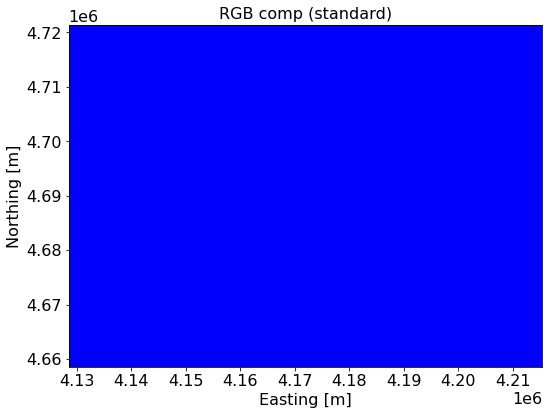

PLAnT 0.1.57dev - plant_display.py --title "RGB comp cropped (standard)" --sel-y "1000:2000" --sel-x "1000:2000" "NETCDF:NISAR_L2_PR_GCOV_001_001_D_001_2800_HH_20190717T231626_20190717T232116_D00001_P_F_001/NISAR_L2_PR_GCOV_001_001_D_001_2800_HH_20190717T231626_20190717T232116_D00001_P_F_001.h5://science/LSAR/GCOV/grids/frequencyA/HHHH" "NETCDF:NISAR_L2_PR_GCOV_001_001_D_001_2800_HH_20190717T231626_20190717T232116_D00001_P_F_001/NISAR_L2_PR_GCOV_001_001_D_001_2800_HH_20190717T231626_20190717T232116_D00001_P_F_001.h5://science/LSAR/GCOV/grids/frequencyA/HVHV" "NETCDF:NISAR_L2_PR_GCOV_001_001_D_001_2800_HH_20190717T231626_20190717T232116_D00001_P_F_001/NISAR_L2_PR_GCOV_001_001_D_001_2800_HH_20190717T231626_20190717T232116_D00001_P_F_001.h5://science/LSAR/GCOV/grids/frequencyA/VVVV" --no-bash
hhhh file:  NETCDF:NISAR_L2_PR_GCOV_001_001_D_001_2800_HH_20190717T231626_20190717T232116_D00001_P_F_001/NISAR_L2_PR_GCOV_001_001_D_001_2800_HH_20190717T231626_20190717T232116_D00001_P_F_001.h5://sci

    blue: file 3 NETCDF:NISAR_L2_PR_GCOV_001_001_D_001_2800_HH_20190717T231626_20190717T232116_D00001_P_F_001/NISAR_L2_PR_GCOV_001_001_D_001_2800_HH_20190717T231626_20190717T232116_D00001_P_F_001.h5://science/LSAR/GCOV/grids/frequencyA/VVVV


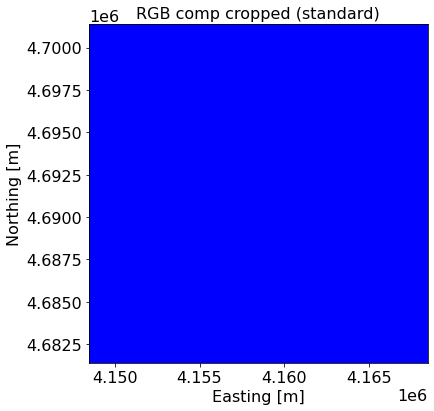

In [52]:
# read in GCOV standard product with plant
std_gcov_file = glob(f"{std_local_dir}/*.h5")[0]
std_hh_obj = f"NETCDF:\"{std_gcov_file}\"://science/LSAR/GCOV/grids/frequencyA/HHHH"
std_hv_obj = f"NETCDF:\"{std_gcov_file}\"://science/LSAR/GCOV/grids/frequencyA/HVHV"
std_vv_obj = f"NETCDF:\"{std_gcov_file}\"://science/LSAR/GCOV/grids/frequencyA/VVVV"
std_vh_obj = f"NETCDF:\"{std_gcov_file}\"://science/LSAR/GCOV/grids/frequencyA/VHVH"

# options
options = {}
# options['mute'] = True
# options['force'] = True

# display options
display_options = options.copy()

# display RGB composition of polarizations HH, HV, VV
plant.display(std_hh_obj, std_hv_obj, std_vv_obj, title="RGB comp (standard)", **display_options)

# show cropped view of RGB composition
plant.display(std_hh_obj, std_hv_obj, std_vv_obj, title="RGB comp cropped (standard)", 
              rows="1000:2000", cols="1000:2000", **display_options)

PLAnT 0.1.57dev - plant_display.py --title "HH pol (standard)" --sel-y "1000:2000" --sel-x "1000:2000" "NETCDF:NISAR_L2_PR_GCOV_001_001_D_001_2800_HH_20190717T231626_20190717T232116_D00001_P_F_001/NISAR_L2_PR_GCOV_001_001_D_001_2800_HH_20190717T231626_20190717T232116_D00001_P_F_001.h5://science/LSAR/GCOV/grids/frequencyA/HHHH" --no-bash
hhhh file:  NETCDF:NISAR_L2_PR_GCOV_001_001_D_001_2800_HH_20190717T231626_20190717T232116_D00001_P_F_001/NISAR_L2_PR_GCOV_001_001_D_001_2800_HH_20190717T231626_20190717T232116_D00001_P_F_001.h5://science/LSAR/GCOV/grids/frequencyA/HHHH
hhhh file:  NETCDF:NISAR_L2_PR_GCOV_001_001_D_001_2800_HH_20190717T231626_20190717T232116_D00001_P_F_001/NISAR_L2_PR_GCOV_001_001_D_001_2800_HH_20190717T231626_20190717T232116_D00001_P_F_001.h5://science/LSAR/GCOV/grids/frequencyA/HHHH
input 1: NETCDF:NISAR_L2_PR_GCOV_001_001_D_001_2800_HH_20190717T231626_20190717T232116_D00001_P_F_001/NISAR_L2_PR_GCOV_001_001_D_001_2800_HH_20190717T231626_20190717T232116_D00001_P_F_001.h

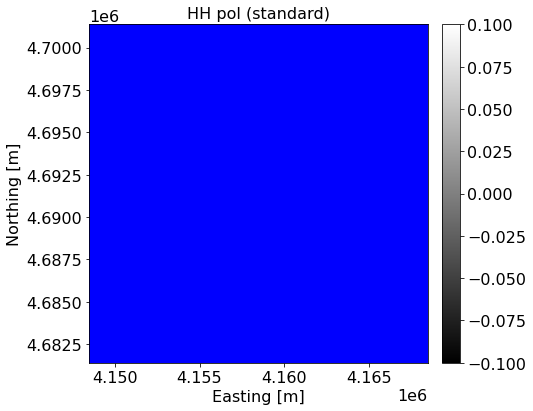

PLAnT 0.1.57dev - plant_display.py --title "HV pol (standard)" --sel-y "1000:2000" --sel-x "1000:2000" "NETCDF:NISAR_L2_PR_GCOV_001_001_D_001_2800_HH_20190717T231626_20190717T232116_D00001_P_F_001/NISAR_L2_PR_GCOV_001_001_D_001_2800_HH_20190717T231626_20190717T232116_D00001_P_F_001.h5://science/LSAR/GCOV/grids/frequencyA/HVHV" --no-bash
hvhv file:  NETCDF:NISAR_L2_PR_GCOV_001_001_D_001_2800_HH_20190717T231626_20190717T232116_D00001_P_F_001/NISAR_L2_PR_GCOV_001_001_D_001_2800_HH_20190717T231626_20190717T232116_D00001_P_F_001.h5://science/LSAR/GCOV/grids/frequencyA/HVHV
hvhv file:  NETCDF:NISAR_L2_PR_GCOV_001_001_D_001_2800_HH_20190717T231626_20190717T232116_D00001_P_F_001/NISAR_L2_PR_GCOV_001_001_D_001_2800_HH_20190717T231626_20190717T232116_D00001_P_F_001.h5://science/LSAR/GCOV/grids/frequencyA/HVHV
input 1: NETCDF:NISAR_L2_PR_GCOV_001_001_D_001_2800_HH_20190717T231626_20190717T232116_D00001_P_F_001/NISAR_L2_PR_GCOV_001_001_D_001_2800_HH_20190717T231626_20190717T232116_D00001_P_F_001.h

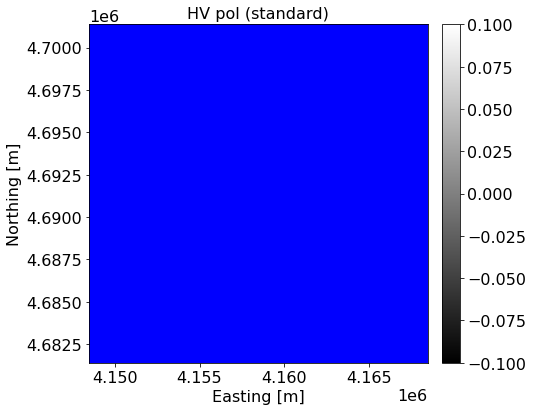

PLAnT 0.1.57dev - plant_display.py --profilex --title "X profile (standard)" "NETCDF:NISAR_L2_PR_GCOV_001_001_D_001_2800_HH_20190717T231626_20190717T232116_D00001_P_F_001/NISAR_L2_PR_GCOV_001_001_D_001_2800_HH_20190717T231626_20190717T232116_D00001_P_F_001.h5://science/LSAR/GCOV/grids/frequencyA/HHHH" "NETCDF:NISAR_L2_PR_GCOV_001_001_D_001_2800_HH_20190717T231626_20190717T232116_D00001_P_F_001/NISAR_L2_PR_GCOV_001_001_D_001_2800_HH_20190717T231626_20190717T232116_D00001_P_F_001.h5://science/LSAR/GCOV/grids/frequencyA/HVHV" --no-bash
hhhh file:  NETCDF:NISAR_L2_PR_GCOV_001_001_D_001_2800_HH_20190717T231626_20190717T232116_D00001_P_F_001/NISAR_L2_PR_GCOV_001_001_D_001_2800_HH_20190717T231626_20190717T232116_D00001_P_F_001.h5://science/LSAR/GCOV/grids/frequencyA/HHHH
hvhv file:  NETCDF:NISAR_L2_PR_GCOV_001_001_D_001_2800_HH_20190717T231626_20190717T232116_D00001_P_F_001/NISAR_L2_PR_GCOV_001_001_D_001_2800_HH_20190717T231626_20190717T232116_D00001_P_F_001.h5://science/LSAR/GCOV/grids/frequ

PlantExceptionError: ERROR <class 'ValueError'>: zero-size array to reduction operation minimum which has no identity

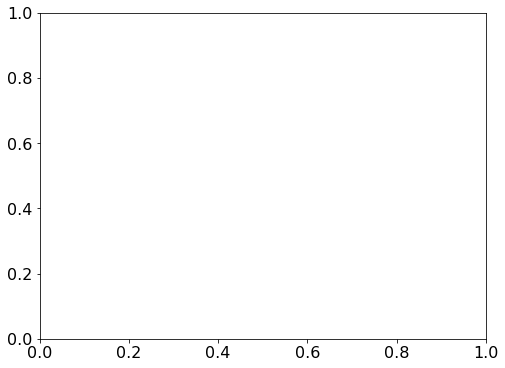

In [53]:
# show cropped view of HH and  HV polarizations
plant.display(std_hh_obj, title="HH pol (standard)", rows="1000:2000", cols="1000:2000", **display_options)
plant.display(std_hv_obj, title="HV pol (standard)", rows="1000:2000", cols="1000:2000", **display_options)

# show profiles
plant.display(std_hh_obj, std_hv_obj, profile_x=True, title='X profile (standard)', **display_options)
plant.display(std_hh_obj, std_hv_obj, profile_y=True, title='Y profile (standard)', **display_options)

## Submitting a "custom on-demand" job for the NISAR GCOV processor with tunable parameters
Next let's submit a GCOV job for the same input product but this time **tweaking 3 of the 5 tunable parameters diverging from the standard product definition**. We will modify the job parameters so that:

- **fullcovariance**: "True" (to compute cross-elements)
- **algorithm_type**: "David-Small" (vs. area-projection)
- **output_posting**: 20 (vs. "[20, 100]")

For the other 2 parameters, we will just accept the default value.

The `prompt_input_params()` method will prompt the user to modify or accept the default value for each of the tunable parameters.

After setting the parameters, we print them again to show what was set.

### Prepare input for the on-demand GCOV processor and modify the tunable parameters

In [ ]:
# set submitter params
gcov.prompt_input_params() # this will prompt user for values for each submitter

### Show the current configured parameter values

In [ ]:
# what are my currently set parameters?
pprint(gcov.get_input_params())

### Submit the GCOV job with tuned parameters to run in the on-demand NISAR SDS
Every on-demand job can be associated with a tag as a value-added feature for improved tracking, billing, and other uses. In the following job submission, we will tag the job with info on the modified parameters.

In [ ]:
# submit job
job2 = gcov.submit_job(tag="gcov-test1-algo_david-small-fullcov_true-posting_20")

### Let's wait for the job to complete generation of the custom GCOV product

In [ ]:
# wait for job
job2.wait_for_completion()

### Get information about the generated custom GCOV product from the GCOV job
#### The generated custom GCOV product is stored in the cloud next to the on-demand NISAR SDS

In [ ]:
cust_prod = job2.get_generated_products()
print(json.dumps(cust_prod, indent=2, sort_keys=True))

### Download the generated custom GCOV product from the cloud into this notebook

In [ ]:
cust_prod_url = re.sub(r'^s3://.+?/(.+)$', r's3://\1', cust_prod[0]["urls"][-1]) # get s3 url
cust_local_dir = os.path.basename(cust_prod_url)
if os.path.isdir(cust_local_dir): shutil.rmtree(cust_local_dir)
!aws s3 sync $cust_prod_url $cust_local_dir

## Use PLAnT to visualize differences between the standard and custom GCOV products

In [ ]:
!ls $cust_local_dir

### Here we show images of the standard vs. custom GCOV products:

In [ ]:
# read in GCOV product with plant
cust_gcov_file = glob(f"{cust_local_dir}/*.h5")[0]
cust_hh_obj = f"NETCDF:\"{cust_gcov_file}\"://science/LSAR/GCOV/grids/frequencyA/HHHH"
cust_hv_obj = f"NETCDF:\"{cust_gcov_file}\"://science/LSAR/GCOV/grids/frequencyA/HVHV"
cust_vv_obj = f"NETCDF:\"{cust_gcov_file}\"://science/LSAR/GCOV/grids/frequencyA/VVVV"
cust_vh_obj = f"NETCDF:\"{cust_gcov_file}\"://science/LSAR/GCOV/grids/frequencyA/VHVH"

# display RGB composition of polarizations HH, HV, VV: standard product vs. custom product
plant.display(std_hh_obj, std_hv_obj, std_vv_obj, title="RGB comp (standard)", **display_options)
plant.display(cust_hh_obj, cust_hv_obj, cust_vv_obj, title="RGB comp (tuned)", **display_options)

# show cropped view of RGB composition: standard product vs. custom product
plant.display(std_hh_obj, std_hv_obj, std_vv_obj, title="RGB comp cropped (standard)",
              rows="1000:2000", cols="1000:2000", **display_options)
plant.display(cust_hh_obj, cust_hv_obj, cust_vv_obj, title="RGB comp cropped (tuned)",
              rows="1000:2000", cols="1000:2000", **display_options)

### Plot histograms of standard vs. custom products in dB

In [ ]:
# show histogram diffs between standard product and custom
plant.display(std_hh_obj, cust_hh_obj, title="HHHH", hist=True, db=True, name="std,tuned", **display_options)
plant.display(std_hv_obj, cust_hv_obj, title="HVHV", hist=True, db=True, name="std,tuned", **display_options)
plant.display(std_vv_obj, cust_vv_obj, title="VVVV", hist=True, db=True, name="std,tuned", **display_options)
plant.display(std_vh_obj, cust_vh_obj, title="VHVH", hist=True, db=True, name="std,tuned", **display_options)

### Plot X and Y profiles of standard vs. custom products

In [ ]:
plant.display(std_hh_obj, std_hv_obj, profile_x=True, title='X profile (standard)', **display_options)
plant.display(cust_hh_obj, cust_hv_obj, profile_x=True, title='X profile (tuned)', **display_options)

In [ ]:
plant.display(std_hh_obj, std_hv_obj, profile_y=True, title='Y profile (standard)', **display_options)
plant.display(cust_hh_obj, cust_hv_obj, profile_y=True, title='Y profile (tuned)', **display_options)

<font size="1">This notebook is compatible with NISAR Jupyter Server Stack v1.4 and above</font>